# Gene classification

Goal: Categorize genes according to their function (e.g., antibiotic resistance, virulence factor, etc.)

In [1]:
import numpy as np
import os
import pandas as pd

from data_utils import fasta_to_contigs, reverse_complement


GENOMES_PATH = "/mnt/datasets/public/research/antibiotic_resistance/genomes/"
CONTIGS_PATH = os.path.join(GENOMES_PATH, "contigs")
CONTIGS_AMR_ONLY_PATH = os.path.join(GENOMES_PATH, "contigs_amr_only")
ANNOTATIONS_PATH = os.path.join(GENOMES_PATH, "annotations")
SPECIALTY_GENES_PATH = os.path.join(GENOMES_PATH, "specialty_genes")
CONTIGS_EXT = ".fna.gz"
CONTIGS_AMR_ONLY_EXT = ".fna"
ANNOTATIONS_EXT = ".PATRIC.features.tab"
SPECIALTY_GENES_EXT = ".PATRIC.spgene.tab"
BYTESTEADY_DATASET_PATH = "/mnt/datasets/public/research/antibiotic_resistance/gene_classification"

In [2]:
metadata = pd.read_csv("/mnt/datasets/public/research/antibiotic_resistance/amr_genes_only/metadata.tsv", sep="\t", converters={"genome_id": str})
genomes = np.unique(metadata.genome_id)

In [3]:
def extract_specialty_genes(genome):
    annotations = pd.read_csv(os.path.join(ANNOTATIONS_PATH, genome + ANNOTATIONS_EXT), sep="\t")
    annotations = annotations.loc[~pd.isna(annotations.patric_id)]
    specialty_genes = pd.read_csv(os.path.join(SPECIALTY_GENES_PATH, genome + SPECIALTY_GENES_EXT), sep="\t")

    specialty_genes = specialty_genes.drop_duplicates("patric_id", keep="first")
    specialty_genes = specialty_genes[["patric_id", "source", "property"]].reset_index()

    # Merge all info
    specialty_genes = pd.merge(specialty_genes, annotations, how="left", on="patric_id", validate="one_to_one")
    return specialty_genes[["accession", "product", "property", "start", "end", "strand"]].dropna()


def extract_gene_sequence(gene_info, contigs):
    gene = contigs[gene_info.accession.lower()][gene_info.start: gene_info.end]
    if gene_info.strand == "-":
        gene = reverse_complement(gene)
    return gene

flatten = lambda l: [item for sublist in l for item in sublist]

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

from joblib.parallel import delayed, Parallel
from tqdm import tqdm


def get_specialty_genes(genome, i, n):
    try:        
        contigs, headers = fasta_to_contigs(os.path.join(CONTIGS_PATH, genome + CONTIGS_EXT), return_headers=True)
        accessions = [h.split()[0] for h in headers]
        contigs = {a: c for a, c in zip(accessions, contigs)}
        if len(contigs) == 0:
            print(Exception("Contig file is empty"))
        
        genes = extract_specialty_genes(genome)
        sequences = [extract_gene_sequence(gene, contigs) for _, gene in genes.iterrows()]
    
    except Exception as e:
#         print(e)
        return None
    
    return [{"accession": g["accession"],
             "sequence": s,
             "product": g["product"],
             "property": g["property"]} for s, (_, g) in zip(sequences, genes.iterrows())]


out = Parallel(40)(delayed(get_specialty_genes)(gid, i, metadata.shape[0]) for i, gid in enumerate(tqdm(metadata.genome_id.values, position=0, leave=True)))
out = [o for o in out if o is not None]
out = flatten(out)
dataset = pd.DataFrame(out)
del out
assert len(np.unique(dataset.accession) == dataset.shape[0])

print(dataset.property.value_counts())
print("Total:", dataset.shape[0])

100%|██████████| 190841/190841 [1:05:05<00:00, 48.87it/s] 


Transporter              31636158
Virulence Factor         23180111
Drug Target              17947879
Antibiotic Resistance    10454445
Human Homolog             2674470
Essential Gene            1098821
Name: property, dtype: int64
Total: 86991884


Filtering genes based on length (min: 100  max: 10000). Current size: 86991884.
Size after filtering: 86774939


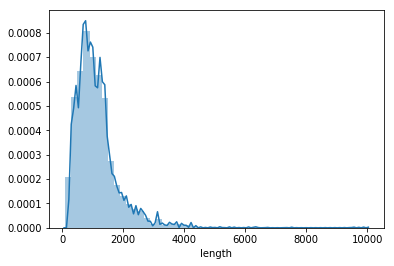

count    8.677494e+07
mean     1.122688e+03
std      7.249445e+02
min      1.000000e+02
25%      6.620000e+02
50%      9.800000e+02
75%      1.376000e+03
max      9.995000e+03
Name: length, dtype: float64

In [5]:
# Gene length stats
dataset["length"] = dataset.sequence.apply(lambda x: len(x))

min_length = 100
max_length = 10000
print("Filtering genes based on length (min: %d  max: %d). Current size: %d." % (min_length, max_length, dataset.shape[0]))
dataset = dataset.loc[(dataset.length >= min_length) & (dataset.length <= max_length)].reset_index()
print("Size after filtering:", dataset.shape[0])

sns.distplot(dataset.length)
plt.show()

dataset.length.describe()

In [6]:
# Remove duplicate sequences
print("Removing duplicate sequences\n----------------------------------")
print("Number of examples before:", dataset.shape[0])
dataset["suid"] = dataset.sequence.apply(hash)
dataset.drop_duplicates("suid", inplace=True)
print("Number of examples after:", dataset.shape[0])

Removing duplicate sequences
----------------------------------
Number of examples before: 86774939
Number of examples after: 11704753


In [7]:
# Balance classes (downsample to smallest class abundance)
class_counts = dataset.property.value_counts()
argmin = np.argmin(class_counts.values)
n_keep = class_counts[argmin]
print("The least abundant class is", class_counts.index[argmin], "(", class_counts[argmin], ")")

# For each class, keep only n_keep examples randomly
random = np.random.RandomState(42)
class_idx = {c: np.where(dataset.property.values == c)[0] for c in class_counts.index.values}
class_idx = {c: random.choice(idx, size=n_keep, replace=False) for c, idx in class_idx.items()}

dataset = dataset.iloc[flatten(class_idx.values())].reset_index()
print(dataset.property.value_counts())
print("Dataset size after balancing:", dataset.shape[0])

The least abundant class is Human Homolog ( 851936 )
Antibiotic Resistance    851936
Transporter              851936
Human Homolog            851936
Essential Gene           851936
Virulence Factor         851936
Drug Target              851936
Name: property, dtype: int64
Dataset size after balancing: 5111616


In [8]:
# Hexadecimal encoding of sequences for bytesteady
from data_utils import *
from binascii import hexlify


def hexify_sequence(seq):
    seq = contig_flag_non_standard(seq)
    seq = hexlify(seq.encode("ascii"))
    return seq.decode("utf-8").upper()

dataset["hex_sequence"] = dataset["sequence"].apply(hexify_sequence)

In [9]:
np.random.seed(42)
idx = np.arange(dataset.shape[0])
np.random.shuffle(idx)

train_size = int(0.8 * len(idx))
valid_size = int(0.1 * len(idx))
test_size = len(idx) - train_size - valid_size

train_idx = idx[: train_size]
valid_idx = idx[train_size : train_size + valid_size]
test_idx = idx[train_size + valid_size :]

label_ids = {l: i for i, l in enumerate(np.unique(dataset.property))}  # TODO: save these for later reference


def write_set(name, idx):
    # Bytesteady dataset
    f = open(os.path.join(BYTESTEADY_DATASET_PATH, "%s.bytesteady" % name.lower()), "w")
    for i in idx:
        row = dataset.iloc[i]
        f.write("%s\t%s\n" % (row.hex_sequence, label_ids[row.property]))
    f.close()
    
    # Kover dataset
    f = open(os.path.join(BYTESTEADY_DATASET_PATH, "%s.cleartext" % name), "w")
    f.write("accession\tsequence\tlabel\n")
    for i in idx:
        row = dataset.iloc[i]
        f.write("%s\t%s\t%d\n" % (row.accession, row.sequence, label_ids[row.property]))
    f.close()
    
write_set("train", train_idx)
write_set("valid", valid_idx)
write_set("test", test_idx)
write_set("train_valid", np.hstack((train_idx, valid_idx)))

open(os.path.join(BYTESTEADY_DATASET_PATH, "label_ids.tsv"), "w").write("label\tid\n" + "\n".join("%s\t%d" % (l, i) for l, i in label_ids.items()))

112

In [17]:
test_idx.shape

(511163,)

98K for testing
90% train 10% test with the rest
Produce a file that is train+valid